In [10]:
import os
import sys
import torch
import numpy as np

from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2

import pickle

import numpy as np

import pybel
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations
from silx.io.dictdump import dicttoh5
import h5py
import click
from   scipy.spatial import ConvexHull, convex_hull_plot_2d
from   numpy.linalg import eig, inv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
def load_pdb(path):

    pdb = PandasPdb().read_pdb(path)
# This just creates a dataframe from the pdb file using biopandas
#print('This is vars',vars(pdb))
    pdf = pdb.df['ATOM']
    x_coords = pdf['x_coord'].values
    y_coords = pdf['y_coord'].values
    z_coords = pdf['z_coord'].values
    atom_types = pdf['atom_name'].values
    residue_names = pdf['residue_name'].values
    
    pro_dict = generate_dict(x_coords, y_coords, z_coords, atom_types, residue_names)
    # add a value to the dictionary, which is all of the atomic coordinates just
    # shifted to the origin
    #protein_dict = shift_coords(protein_dict)

    return pro_dict



def load_mol2(path):
    
    mol = PandasMol2().read_mol2(path)
    pdf = mol
    x_coords = pdf.df['x'].values
    y_coords = pdf.df['y'].values
    z_coords = pdf.df['z'].values
    atom_types = pdf.df['atom_name'].values
    residue_names = pdf.df['subst_name'].values
    partial_charge = pdf.df['charge'].values
    smarts_notation = next(pybel.readfile('mol2', path))
    
    pro_dict = generate_dict(x_coords, y_coords, z_coords, atom_types, residue_names)
    heavy_pos = heavy_atom_positions(x_coords, y_coords, z_coords, atom_types)

    pro_dict['charge'] = partial_charge
    pro_dict['smarts'] = smarts_notation
    pro_dict['heavy_atom_positions'] = heavy_pos

    # add a value to the dictionary, which is all of the atomic coordinates just
    # shifted to the origin
    #protein_dict = shift_coords(protein_dict)

    return pro_dict
    
def generate_dict(x, y, z, a_types, res_names):
    
    positions = []
    for i, xi in enumerate(x):
        position_tuple = (x[i], y[i], z[i])
        positions.append(position_tuple)
    positions = np.array(positions)

    # names of all the atoms contained in the protein
    
    num_atoms = len(a_types)
    atom_type_set = np.unique(a_types)
    num_atom_types = len(atom_type_set)

    # residue names
    
    residue_set = np.unique(res_names)

    pro_dict = {'x_coords':x, 'y_coords':y, 'z_coords':z,
                    'positions':positions, 'atom_types':a_types,
                    'num_atoms':num_atoms, 'atom_type_set':atom_type_set,
                    'num_atom_types':num_atom_types, 'residues':res_names,
                    'residue_set':residue_set}
    
    return pro_dict

def heavy_atom_positions(x, y, z, a_types):
    
    positions = []
    for i, xi in enumerate(x):
        if a_types[i].startswith('H'):
            pass
        else:
            position_tuple = (x[i], y[i], z[i])
            positions.append(position_tuple)
    positions = np.array(positions)
    
    return positions


def load_input(path, ligand=False):
    """
    Loads all of the atomic positioning/type arrays from a pdb/mol2 file.
    The arrays can then be transformed into density (or "field") tensors before
        being sent through the neural network.
    Parameters:
        path (str, required): The full path to the pdb file being voxelized.
    Returns:
        dictionary: A dictionary containing the following arrays from
            the pdb file: num_atoms, atom_types, positions, atom_type_set,
            xcoords, ycoords, zcoords, residues, residue_set
    """
    
    file_type = path.split('.')[-1]
    
    if file_type == 'pdb':
        protein_dict = load_pdb(path)
    
    elif file_type == 'mol2':
        protein_dict = load_mol2(path)
    else:
        raise ValueError('Need a pdb or mol2 file')
    # atomic coordinates
    if ligand == True:
        ligand_file = path.split('_')[:-1][0] + '_ligand.mol2'
        ligand_dict = load_mol2(ligand_file)
        mid_points = shift_coords(protein_dict, lig_dict=ligand_dict)
        #mid_points = shift_coords(ligand_dict, lig_dict=None)
        protein_dict['shifted_positions'] = protein_dict['positions'] - mid_points
        ligand_dict['shifted_positions'] = ligand_dict['positions'] - mid_points
        
        return protein_dict, ligand_dict
    else:
        mid_points = shift_coords(protein_dict)
        protein_dict['shifted_positions'] = protein_dict['positions'] - mid_points
        
        return protein_dict
        

    # create an array containing tuples of x,y,z for every atom
    
def get_extreme_values(name_dict):
    
    x_ext = np.array([name_dict['x_coords'].min(), name_dict['x_coords'].max()])
    y_ext = np.array([name_dict['y_coords'].min(), name_dict['y_coords'].max()])
    z_ext = np.array([name_dict['z_coords'].min(), name_dict['z_coords'].max()])
    
    return x_ext, y_ext, z_ext

def shift_coords(pro_dict, lig_dict=None):
    """
    This function shifts the coordinates of a protein so that it's coordinates are in the center
    of the field tensor.
    Parameters:
        protein_dict (dict): A dictionary of information from the first part of the load_input function.
    Returns:
        dictionary: The original protein dict but with an added value containing
            the coordinates of the protein shifted to the origin.
    """
    # find the extreme x, y, and z values that exist in the protein atomic coordinates
 
    x_extremes, y_extremes, z_extremes = get_extreme_values(pro_dict)
        

    if lig_dict:
        x_pro, y_pro, z_pro = get_extreme_values(pro_dict)
        x_lig, y_lig, z_lig = get_extreme_values(lig_dict)
        x_extremes, y_extremes, z_extremes = get_extreme_values(lig_dict)
        
#         x_extremes = np.array([np.min(np.concatenate([x_pro, x_lig])), np.max(np.concatenate([x_pro, x_lig]))])
#         y_extremes = np.array([np.min(np.concatenate([y_pro, y_lig])), np.max(np.concatenate([y_pro, y_lig]))])
#         z_extremes = np.array([np.min(np.concatenate([z_pro, z_lig])), np.max(np.concatenate([z_pro, z_lig]))])
        
        #x_val = np.concatenate(x_pro, x_lig)
        #print(x_extremes)
    # calculate the midpoints of the extremes
    midpoints = [np.sum(x_extremes)/2, np.sum(y_extremes)/2, np.sum(z_extremes)/2]
#     print(x_extremes, y_extremes, z_extremes)

    # shift the coordinates by the midpoints of those extremes (center the protein on the origin)
#     protein_dict['shifted_positions'] = protein_dict['positions'] - midpoints

    return midpoints
    
   

In [12]:
# def ls_ellipsoid(xx,yy,zz):                                  
#     #finds best fit ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
#     #least squares fit to a 3D-ellipsoid
#     #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
#     #
#     # Note that sometimes it is expressed as a solution to
#     #  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
#     # where the last six terms have a factor of 2 in them
#     # This is in anticipation of forming a matrix with the polynomial coefficients.
#     # Those terms with factors of 2 are all off diagonal elements.  These contribute
#     # two terms when multiplied out (symmetric) so would need to be divided by two
    
#     # change xx from vector of length N to Nx1 matrix so we can use hstack
#     x = xx[:,np.newaxis]
#     y = yy[:,np.newaxis]
#     z = zz[:,np.newaxis]
    
#     #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
#     J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
#     K = np.ones_like(x) #column of ones
    
#     #np.hstack performs a loop over all samples and creates
#     #a row in J for each x,y,z sample:
#     # J[ix,0] = x[ix]*x[ix]
#     # J[ix,1] = y[ix]*y[ix]
#     # etc.
    
#     JT=J.transpose()
#     JTJ = np.dot(JT,J)
#     InvJTJ=np.linalg.inv(JTJ);
#     ABC= np.dot(InvJTJ, np.dot(JT,K))

#     # Rearrange, move the 1 to the other side
#     #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
#     #    or
#     #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
#     #  where J = -1
#     eansa=np.append(ABC,-1)

#     return (eansa)

# def polyToParams3D(vec,printMe):                             
#     #gets 3D parameters of an ellipsoid. Found at http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html
#     # convert the polynomial form of the 3D-ellipsoid to parameters
#     # center, axes, and transformation matrix
#     # vec is the vector whose elements are the polynomial
#     # coefficients A..J
#     # returns (center, axes, rotation matrix)
    
#     #Algebraic form: X.T * Amat * X --> polynomial form
    
#     if printMe: print('\npolynomial\n',vec)
    
#     Amat=np.array(
#     [
#     [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
#     [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
#     [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
#     [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
#     ])
    
#     if printMe: print('\nAlgebraic form of polynomial\n',Amat)
    
#     #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
#     # equation 20 for the following method for finding the center
#     A3=Amat[0:3,0:3]
#     A3inv=inv(A3)
#     ofs=vec[6:9]/2.0
#     center=-np.dot(A3inv,ofs)
#     if printMe: print('\nCenter at:',center)
    
#     # Center the ellipsoid at the origin
#     Tofs=np.eye(4)
#     Tofs[3,0:3]=center
#     R = np.dot(Tofs,np.dot(Amat,Tofs.T))
#     if printMe: print('\nAlgebraic form translated to center\n',R,'\n')
    
#     R3=R[0:3,0:3]
#     R3test=R3/R3[0,0]
#     # print('normed \n',R3test)
#     s1=-R[3, 3]
#     R3S=R3/s1
#     (el,ec)=eig(R3S)
    
#     recip=1.0/np.abs(el)
#     axes=np.sqrt(recip)
#     if printMe: print('\nAxes are\n',axes  ,'\n')
    
#     inve= -1 * inv(ec) #inverse is actually the transpose here
#     if printMe: print('\nRotation matrix\n',inve)
#     return (center,axes,inve)

# def convex_hull(ligand_heavy_atoms):
#     """
#     """
#     surface  = np.stack((ligand_heavy_atoms[:,0], ligand_heavy_atoms[:,1], 
#                          ligand_heavy_atoms[:,2]), axis=-1)
#     hullV    = ConvexHull(surface)
#     lH       = len(hullV.vertices)
#     hull     = np.zeros((lH,3))
#     for i in range(len(hullV.vertices)):
#         hull[i] = surface[hullV.vertices[i]]
#     hull     = np.transpose(hull)  
    
#     return hull

# def get_ellipsoid(ligand_heavy_atoms):
#     hull = convex_hull(ligand_heavy_atoms)
#     eansa = ls_ellipsoid(hull[0], hull[1], hull[2]) #get ellipsoid polynomial coefficients
#     center, axes, rotation_mat = polyToParams3D(eansa,False)
#     return center, axes, rotation_mat

# def rotate_position(ligand_heavy, ligand_all, protein_all, center, rotation_mat):
    

#     ligand_heavy = ligand_heavy - center
#     ligand_heavy_rotated = np.dot(ligand_heavy, rotation_mat)
    
#     ligand_all = ligand_all - center 
#     ligand_rotated = np.dot(ligand_all, rotation_mat)
    
#     protein_all = protein_all - center 
#     protein_rotated = np.dot(protein_all, rotation_mat)
    
#     return protein_rotated, ligand_rotated, ligand_heavy_rotated


# def ellipsoid_plot(center, radii, rotation, ax, plot_axes=False, cage_color='b', cage_alpha=0.2):
#     """Plot an ellipsoid"""
        
#     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     v = np.linspace(0.0, np.pi, 100)
    
#     # cartesian coordinates that correspond to the spherical angles:
#     x = radii[0] * np.outer(np.cos(u), np.sin(v))
#     y = radii[1] * np.outer(np.sin(u), np.sin(v))
#     z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
#     # rotate accordingly
#     for i in range(len(x)):
#         for j in range(len(x)):
#             [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation) + center

#     if plot_axes:
#         # make some purdy axes
#         axes = np.array([[radii[0],0.0,0.0],
#                          [0.0,radii[1],0.0],
#                          [0.0,0.0,radii[2]]])
#         # rotate accordingly
#         for i in range(len(axes)):
#             axes[i] = np.dot(axes[i], rotation)

#         # plot axes
#         for p in axes:
#             X3 = np.linspace(-p[0], p[0], 100) + center[0]
#             Y3 = np.linspace(-p[1], p[1], 100) + center[1]
#             Z3 = np.linspace(-p[2], p[2], 100) + center[2]
#             ax.plot(X3, Y3, Z3, color=cage_color)

#     # plot ellipsoid
#     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cage_color, alpha=cage_alpha)
    
# def rot2eul(R):
#     beta = -np.arcsin(R[2,0])
#     alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
#     gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
#     return np.array((alpha, beta, gamma))
    
def voxelize(path, path_type='file', ligand=False):
    """
    This function creates a dictionary of tensor fields directly from a pdb file.
    These tensor fields can be plotted, or sent directly into the cnn for
        plotting internals, or sent all the way through a cnn/vae to be used for
        training.
    Parameters:
        path (str, required): path to a .pdb file
        channels (list of strings, optional): The list of atomic channels to be included in
            the output dictionary, one field for every channel.
            Any channels from points 1-4 below may be combined in any order.
            i.e., one could call voxelize with the channels parameter as
            channels=['charged', 'CB', 'GLY', 'polar', ...etc]. Note that voxelization
            for channels containing more atoms will take longer.
            1. any of the following atom types
                ['C' 'CA' 'CB' 'CD' 'CD1' 'CD2' 'CE' 'CE1' 'CE2' 'CE3' 'CG' 'CG1' 'CG2'
                'CH2' 'CZ' 'CZ2' 'CZ3' 'N' 'ND1' 'ND2' 'NE' 'NE1' 'NE2' 'NH1' 'NH2' 'NZ'
                'O' 'OD1' 'OD2' 'OE1' 'OE2' 'OG' 'OG1' 'OH' 'OXT' 'SD' 'SG']
            2. Any canonical residue in the protein, using the three letter residue code, all caps
               (NOTE: the residue must actually exist in the protein)
                e.g., ['LYS', 'LEU', 'ALA']
            3. The 'other' channel options: 'backbone', 'sidechains'
            4. There are 6 channels corresponding to specific types of residues:
                'charged', 'polar', 'nonpolar', 'amphipathic', 'acidic', 'basic'
    Returns:
        dictionary: a dictionary containing a voxelized atomic fields, one for each
        channel requested. Each field has shape = ([1, 1, 50, 50, 50])
    """
    if path_type == 'file':
        pro_dict = load_input(path, ligand=ligand)
        if ligand == True:
            protein_dict = pro_dict[0]
            ligand_dict = pro_dict[1]
            ligand_heavy = ligand_dict['heavy_atom_positions']
            ligand = ligand_dict['positions']
            protein = protein_dict['positions']
            
            x_ext = np.array([ligand[:,0].min(), ligand[:,0].max()])
            y_ext = np.array([ligand[:,1].min(), ligand[:,1].max()])
            z_ext = np.array([ligand[:,2].min(), ligand[:,2].max()])
            
            midpoints = [np.sum(x_ext)/2, np.sum(y_ext)/2, np.sum(z_ext)/2]
            ligand = ligand - midpoints
            protein = protein - midpoints
            ligand_heavy = ligand_heavy - midpoints
            
            # get ellipsoid parameters at the original positions of the 
            # ligand heavy atoms
            #center, axis, rotation_mat = get_ellipsoid(ligand_heavy)
            
            ET = EllipsoidTool()
            (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01)
            
#             ligand_heavy = np.dot(ligand_heavy, np.transpose(rotation))
#             protein, ligand, ligand_heavy = ET.rotate_position(ligand_heavy, ligand, protein, 
#                                                           center, np.transpose(rotation))
            
#             (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01)
            
#             rotation = np.array([[0.707, 0, 0.707], 
#                                     [0.5, 0.707, -0.5], 
#                                     [-0.5, 0.707, 0.5]])
#             protein, ligand, ligand_heavy = ET.rotate_position(ligand_heavy, ligand, protein, 
#                                               center, np.transpose(rotation))

#             (center, radii, rotation) = ET.getMinVolEllipse(ligand_heavy, .01) 
            return protein, ligand, ligand_heavy, center, radii, rotation
        else:
            protein_dict = pro_dict
            sys.stdout.write('done')
            return make_fields(protein_dict, channels=channels, bin_size=bin_size, num_bins=num_bins)
    

In [13]:
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy import linalg
from random import random

class EllipsoidTool:
    """Some stuff for playing with ellipsoids"""
    def __init__(self): pass
    
    def getMinVolEllipse(self, P=None, tolerance=0.01):
        """ Find the minimum volume ellipsoid which holds all the points
        
        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!
        
        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]
        
        Returns:
        (center, radii, rotation)
        
        """
        (N, d) = np.shape(P)
        d = float(d)
    
        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)]) 
        QT = Q.T
        
        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse 
        center = np.dot(P.T, u)
    
        # the A matrix for the ellipse
        A = linalg.inv(
                       np.dot(P.T, np.dot(np.diag(u), P)) - 
                       np.array([[a * b for b in center] for a in center])
                       ) / d
                       
        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0/np.sqrt(s)
        
        return (center, radii, rotation)

    def getEllipsoidVolume(self, radii):
        """Calculate the volume of the blob"""
        return 4./3.*np.pi*radii[0]*radii[1]*radii[2]

    def plotEllipsoid(self, center, radii, rotation, ax=None, plotAxes=False, 
                      legend='', cageColor='b', cageAlpha=0.2):
        """Plot an ellipsoid"""
        make_ax = ax == None
        if make_ax:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            
        u = np.linspace(0.0, 2.0 * np.pi, 100)
        v = np.linspace(0.0, np.pi, 100)
        
        # cartesian coordinates that correspond to the spherical angles:
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        # rotate accordingly
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    
        if plotAxes:
            # make some purdy axes
            axes = np.array([[radii[0],0.0,0.0],
                             [0.0,radii[1],0.0],
                             [0.0,0.0,radii[2]]])
            # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)
    
    
            # plot axes
            for p in axes:
                X3 = np.linspace(-p[0], p[0], 100) + center[0]
                Y3 = np.linspace(-p[1], p[1], 100) + center[1]
                Z3 = np.linspace(-p[2], p[2], 100) + center[2]
                ax.plot(X3, Y3, Z3, color=cageColor)
    
        # plot ellipsoid
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor,
                          alpha=cageAlpha)
        
        if make_ax:
            plt.show()
            plt.close(fig)
            del fig
            
    def rotate_position(self, ligand_heavy, ligand_all, protein_all, center, rotation_mat):


        ligand_heavy = ligand_heavy - center
        ligand_heavy_rotated = np.dot(ligand_heavy, rotation_mat)

        ligand_all = ligand_all - center 
        ligand_rotated = np.dot(ligand_all, rotation_mat)

        protein_all = protein_all - center 
        protein_rotated = np.dot(protein_all, rotation_mat)

        return protein_rotated, ligand_rotated, ligand_heavy_rotated
        
# if __name__ == "__main__":
#     # make 100 random points
#     P = np.reshape([random()*100 for i in range(300)],(100,3))

#     # find the ellipsoid
#     ET = EllipsoidTool()
#     (center, radii, rotation) = ET.getMinVolEllipse(P, .01)

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # plot points
#     ax.scatter(P[:,0], P[:,1], P[:,2], color='g', marker='*', s=100)

#     # plot ellipsoid
#     ET.plotEllipsoid(center, radii, rotation, ax=ax, plotAxes=True)
    
#     plt.show()
#     plt.close(fig)
#     del fig

In [14]:
protein1, ligand1, ligand_heavy1, center1, radii1, rotation_mat1 = voxelize('1a1b_pocket.mol2', ligand=True)

ET = EllipsoidTool()

#             ligand_heavy = np.dot(ligand_heavy, np.transpose(rotation))
protein2, ligand2, ligand_heavy2 = ET.rotate_position(ligand_heavy1, ligand1, protein1, 
                                              center1, np.transpose(rotation_mat1))

center2, radii2, rotation2 = ET.getMinVolEllipse(ligand_heavy2, .01)

rotation = np.array([[0.707, 0, 0.707], 
                        [0.5, 0.707, -0.5], 
                        [-0.5, 0.707, 0.5]])
protein3, ligand3, ligand_heavy3 = ET.rotate_position(ligand_heavy2, ligand2, protein2, 
                                  center2, np.transpose(rotation))

center3, radii3, rotation3 = ET.getMinVolEllipse(ligand_heavy3, .01)

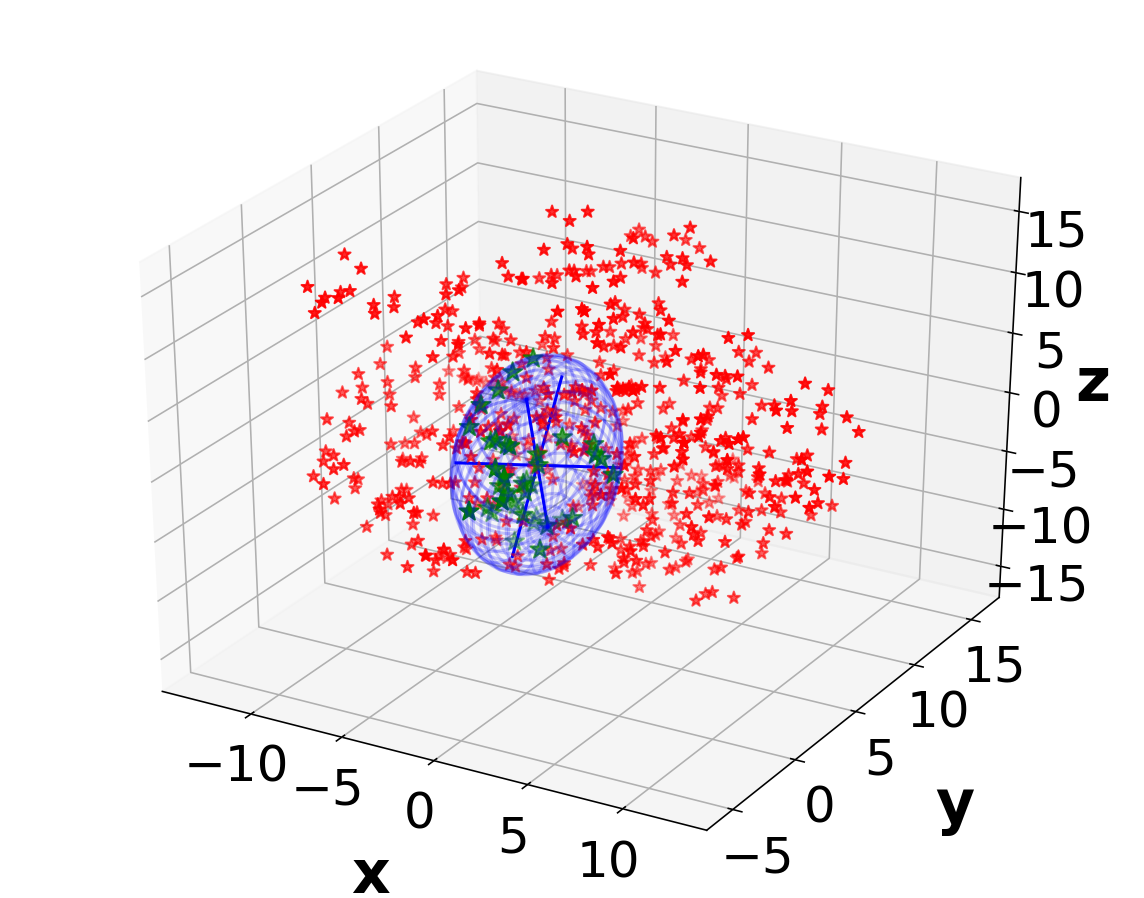

In [20]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# fig = plt.figure()
# ax = Axes3D(fig)
# ellipsoid_plot([0, 0, 0], axis1, rotation_mat1, ax)
plt.rc('xtick', labelsize=25)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')

# plot points
ax.scatter(ligand_heavy1[:,0], ligand_heavy1[:,1], ligand_heavy1[:,2], color='g', marker='*', s=100)
ax.scatter(protein1[:,0] , protein1[:,1], protein1[:,2], color='red',  marker='*', s=40)
ET = EllipsoidTool()
# plot ellipsoid
ET.plotEllipsoid(center1, radii1, rotation_mat1, ax=ax, plotAxes=True)
ax.set_xlabel('x', fontsize=30, fontweight='bold', labelpad=25)
ax.set_ylabel('y', fontsize=30, fontweight='bold', labelpad=25)
ax.set_zlabel('z', fontsize=30, fontweight='bold', labelpad=5)
plt.savefig('fig/original.png', dpi=600)
plt.show()


# ax.scatter(protein1[:,0] , protein1[:,1], protein1[:,2], color='red')

# ax.scatter(ligand_heavy1[:,0] , ligand_heavy1[:,1], ligand_heavy1[:,2], color='green')

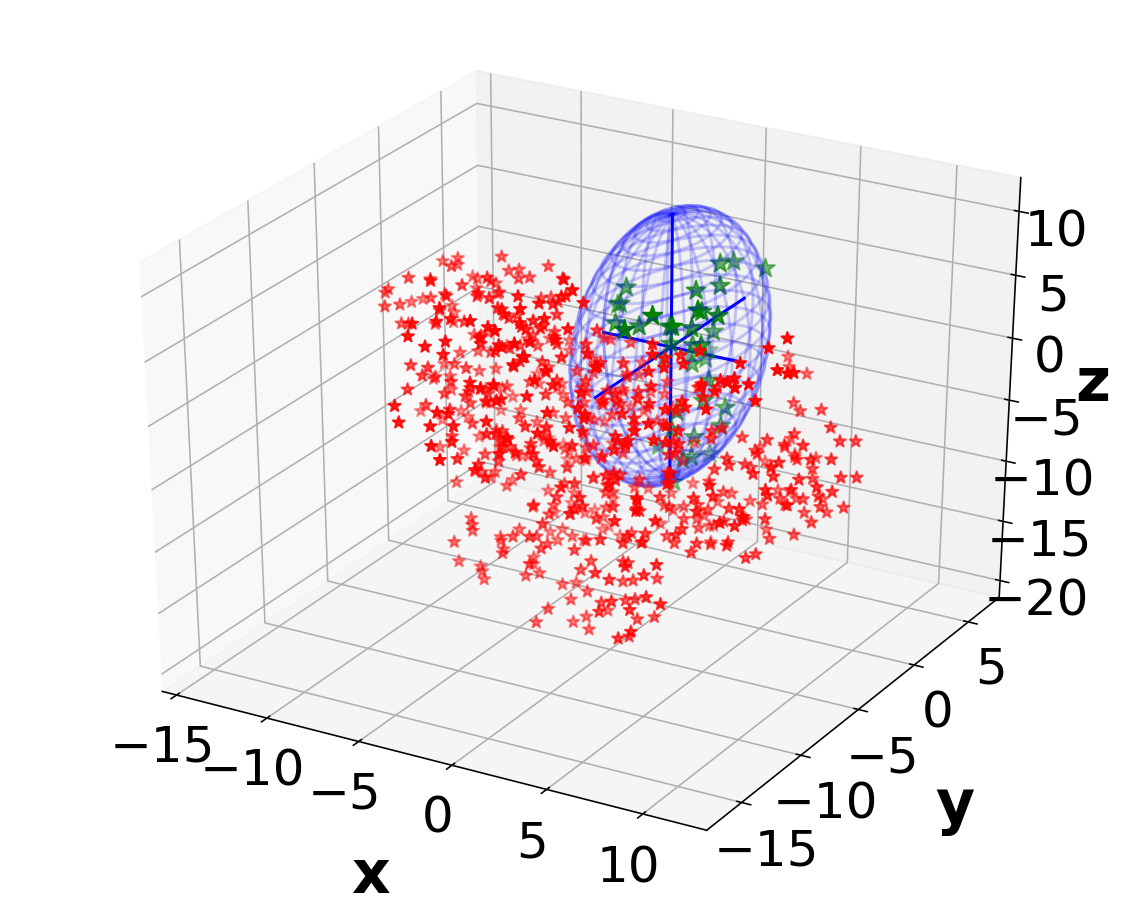

In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# fig = plt.figure()
# ax = Axes3D(fig)
# ellipsoid_plot([0, 0, 0], axis1, rotation_mat1, ax)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# plot points
ax.scatter(ligand_heavy2[:,0], ligand_heavy2[:,1], ligand_heavy2[:,2], color='g', marker='*', s=100)
ax.scatter(protein2[:,0] , protein2[:,1], protein2[:,2], color='red',  marker='*', s=40)
ET = EllipsoidTool()
# plot ellipsoid
ET.plotEllipsoid(center2, radii2, rotation2, ax=ax, plotAxes=True)
ax.set_xlabel('x', fontsize=30, fontweight='bold', labelpad=25)
ax.set_ylabel('y', fontsize=30, fontweight='bold', labelpad=25)
ax.set_zlabel('z', fontsize=30, fontweight='bold', labelpad=5)
plt.savefig('fig/aligned.png', dpi=600)
plt.show()


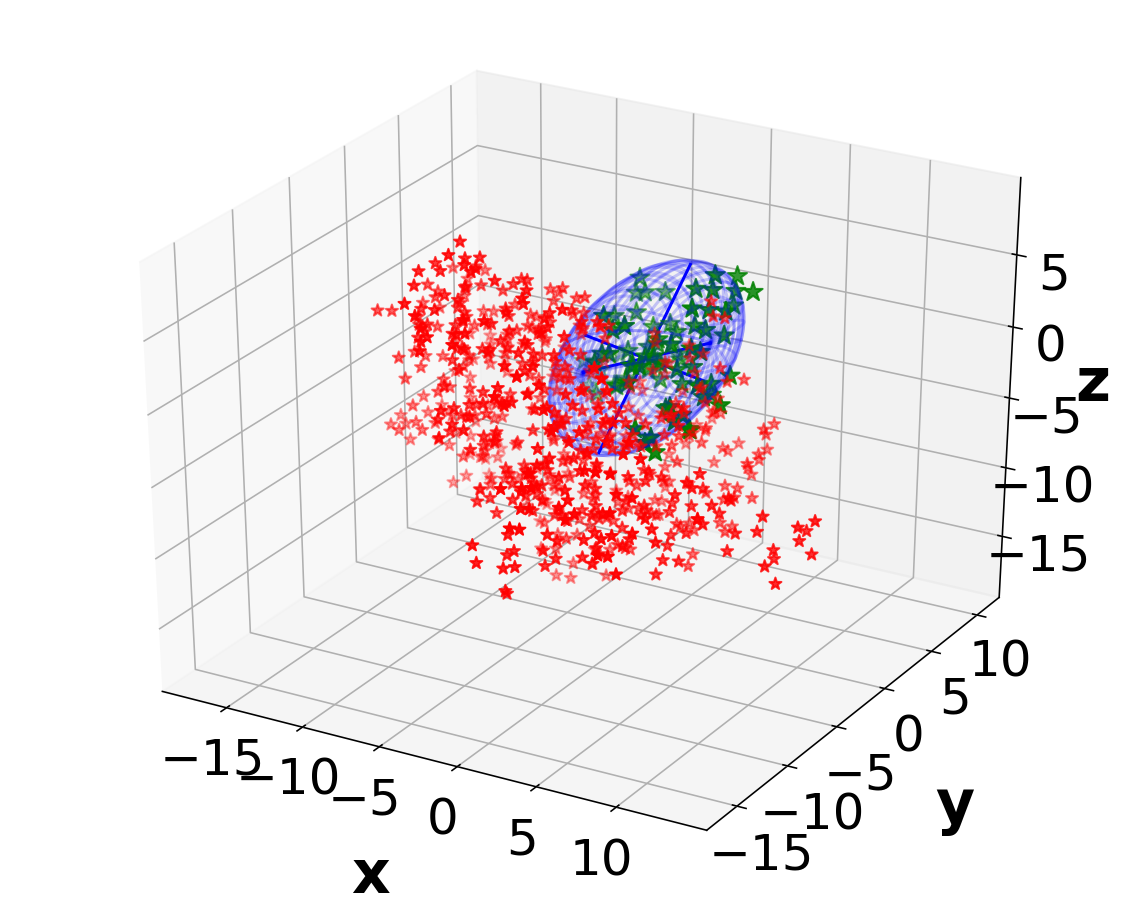

In [22]:
#%matplotlib qt
%matplotlib inline
%config InlineBackend.figure_format='retina'
# fig = plt.figure()
# ax = Axes3D(fig)
# ellipsoid_plot([0, 0, 0], axis1, rotation_mat1, ax)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# plot points
#ax.scatter(ligand_heavy3[:,0], ligand_heavy3[:,1], ligand_heavy3[:,2], color='g', marker='*', s=100)
ax.scatter(ligand3[:,0], ligand3[:,1], ligand3[:,2], color='g', marker='*', s=100)

ax.scatter(protein3[:,0] , protein3[:,1], protein3[:,2], color='red',  marker='*', s=40)
ET = EllipsoidTool()
# plot ellipsoid
ET.plotEllipsoid(center3, radii3, rotation3, ax=ax, plotAxes=True)
ax.set_xlabel('x', fontsize=30, fontweight='bold', labelpad=25)
ax.set_ylabel('y', fontsize=30, fontweight='bold', labelpad=25)
ax.set_zlabel('z', fontsize=30, fontweight='bold', labelpad=5)
plt.savefig('fig/rotated.png', dpi=600)
plt.show()


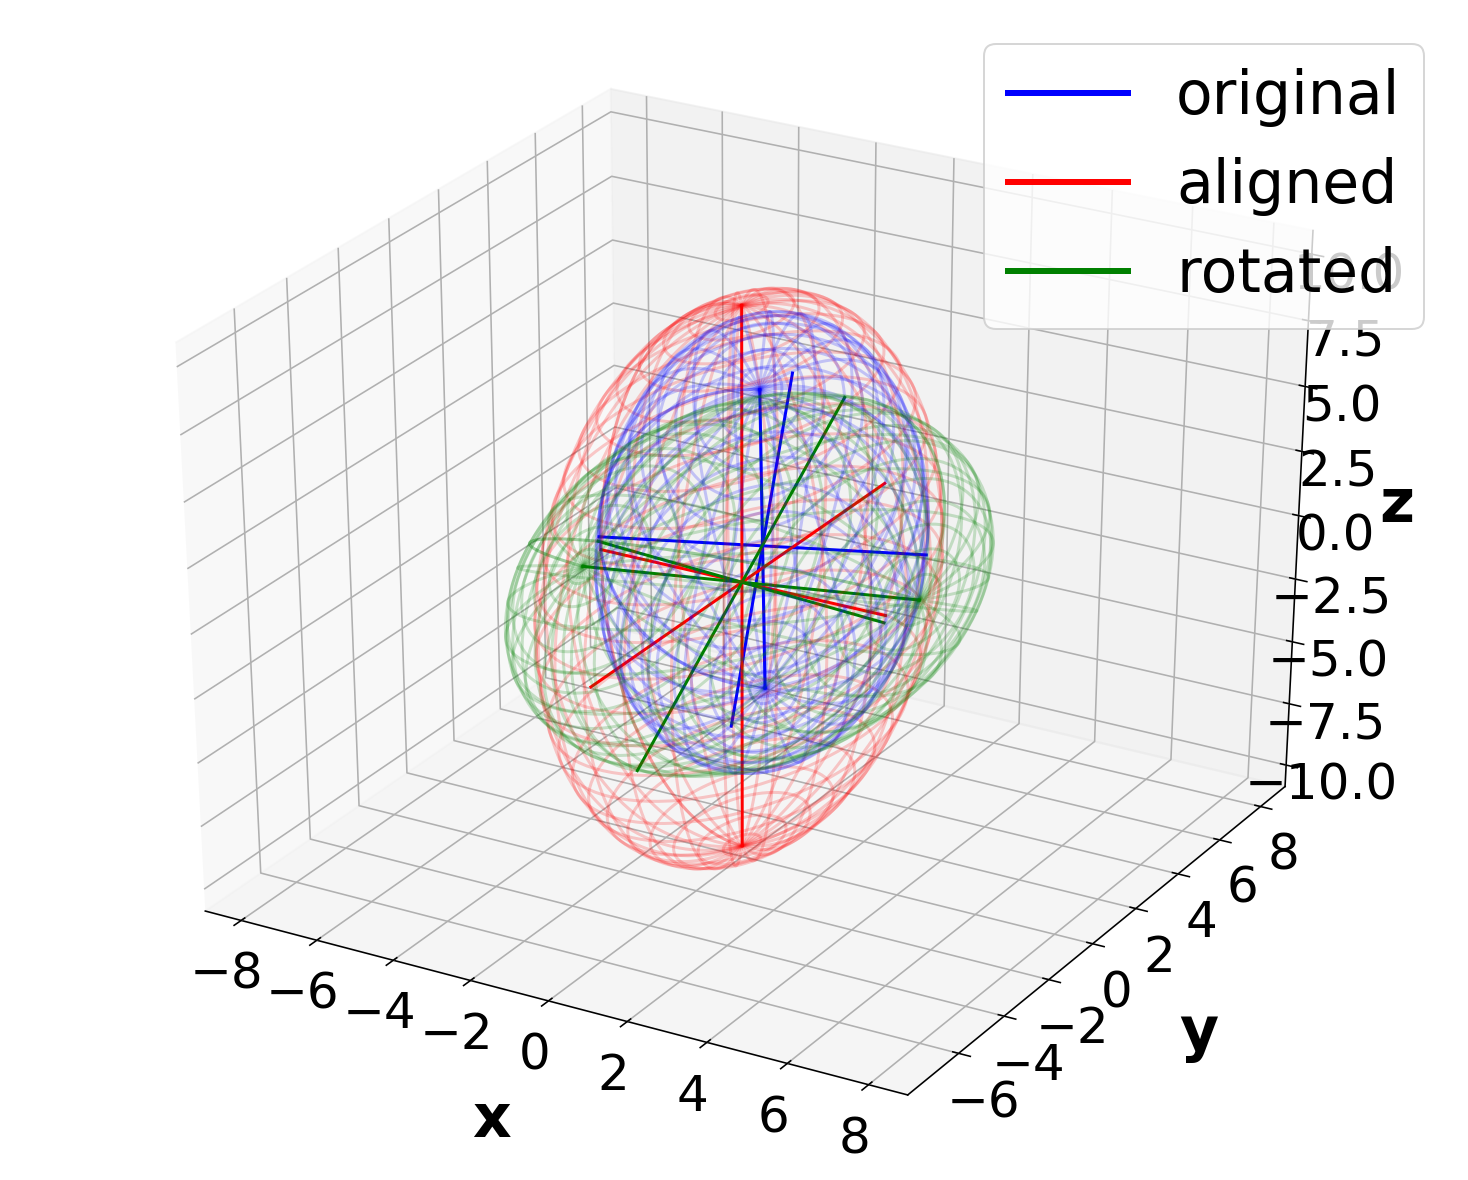

In [25]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(10,8))

ax = Axes3D(fig)
ET.plotEllipsoid(center1, radii1, rotation_mat1, ax=ax, plotAxes=True)
ET.plotEllipsoid(center2, radii2, rotation2, ax=ax, plotAxes=True, cageColor='red')
ET.plotEllipsoid(center3, radii3, rotation3, ax=ax, plotAxes=True, cageColor='green')
ax.set_xlabel('x', fontsize=30, fontweight='bold', labelpad=25)
ax.set_ylabel('y', fontsize=30, fontweight='bold', labelpad=25)
ax.set_zlabel('z', fontsize=30, fontweight='bold', labelpad=10)
legend_elements = [Line2D([0], [0], color = 'b', lw = 3, label = 'original'),
                  Line2D([0], [0], color = 'r', lw = 3, label = 'aligned'),
                  Line2D([0], [0], color = 'g', lw = 3, label = 'rotated')]

# ax.figure.legend(['original', 'aligned', 'rotated'],
#                 fontsize=20, bbox_to_anchor=(1.,1),
#                 loc='upper right', bbox_transform=ax.transAxes)
ax.legend(handles=legend_elements, loc='upper right', fontsize=30)


plt.savefig('fig/ellipsoid.png', dpi=600)

In [ ]:
radii2

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ligand_heavy1[:,0], ligand_heavy1[:,1], ligand_heavy1[:,2], color='b')
ax.scatter(ligand_heavy2[:,0], ligand_heavy2[:,1], ligand_heavy2[:,2], color='r')
ax.scatter(ligand_heavy3[:,0], ligand_heavy3[:,1], ligand_heavy3[:,2], color='g')
ax.set_xlabel('x', fontsize=30, fontweight='bold', labelpad=25)
ax.set_ylabel('y', fontsize=30, fontweight='bold', labelpad=25)
ax.set_zlabel('z', fontsize=30, fontweight='bold', labelpad=5)

In [ ]:
atoms = []

for item in aa:
    if item[0] > -15 and item[0] < 15:
        if item[1] > -15 and item[1] < 15:
            if item[2] > -15 and item[2] < 15:
                atoms.append(item)
                
print(len(atoms))

In [ ]:
mol_file = PandasMol2().read_mol2('1a1b_ligand.mol2')


In [ ]:
lines = mol_file.mol2_text.split('\n')
# for item in line:
#     print(line)

with open ('new_3.mol2', 'w') as f:
    
    atom_count = 0
    for i, line in enumerate(lines):
        
        
        if i > 7 and i < 86:
            zz = line.split(' ')
            count = 0
            for j, item in enumerate(zz):
                if item is not '':
                    if count > 1:
                        zz[j] = str(round(ligand3[atom_count][count-3], 5))
                    count = count + 1
                    if count > 4:
                        break
            atom_count = atom_count + 1
            line = ' '.join(zz)
            
        f.write(line)
        f.write('\n')

In [ ]:
import torch

atom_positions = torch.FloatTensor(ligand3)

In [ ]:
num_bins = 20
bin_size = 1.0
grid_1d = torch.linspace(start=-num_bins / 2 * bin_size + bin_size / 2,
                             end=num_bins / 2 * bin_size - bin_size / 2,
                             steps=num_bins)

In [ ]:
grid_1d

In [ ]:
xgrid = grid_1d.view(-1, 1, 1).repeat(1, len(grid_1d), len(grid_1d))
xgrid = grid_1d.view(-1, 1, 1)
xx_xx = xgrid.view(-1, 1).repeat(1, len(atom_positions))
xx_xx.shape

In [ ]:
posx_posx = atom_positions[:, 0].contiguous().view(1, -1).repeat(len(xgrid.view(-1)), 1)
posx_posx.shape

In [ ]:
bin_size = torch.tensor(float(bin_size))
sigma = 0.5*bin_size
sigma

In [ ]:
density = torch.exp(-((xx_xx - posx_posx)**2) / (2 * (sigma)**2))
xs = torch.sum(density, dim=0)

In [ ]:
# density = density / torch.sum(density, dim=0)
zz = density[0].numpy()
density.shape

In [ ]:
c = torch.sum(density, dim=0)
c

In [ ]:
sum_densities = torch.sum(density, dim=1).view(xgrid.shape)
cc = sum_densities.numpy().flatten()
xgrid = xgrid.flatten()
cc

In [ ]:
plt.plot(xgrid, cc)

In [ ]:
sum_densities[sum_densities != sum_densities] = 0

In [ ]:
ligand3[:,0]

In [ ]:
r = R.from_matrix(zz)

In [ ]:
pip freeze | grep scipy

In [ ]:
conda install -c anaconda scipy=1.5


In [ ]:
%config InlineBackend.figure_format='retina'

y = [7300, 50]

method = ['CPU', 'GPU']
x = np.arange(len(method))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x, y, width)
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(method)
ax.set_ylabel('Time (min)')
ax.set_xlabel('Method')